Sistema baseado na rede de distribuição de gás natural

1 Duto

equações :
$$
\frac{\partial}{\partial t}
\begin{bmatrix}
T \\
V \\
w
\end{bmatrix}
=
\begin{bmatrix}
-w & 0 & -T \frac{V^{*} P'_T}{C_V} \\
0 & -w & V \\
- V^{*} P'_T & -V^{*} P'_V & -w
\end{bmatrix}
\frac{\partial}{\partial x}
\begin{bmatrix}
T \\
V \\
w
\end{bmatrix}
+
\begin{bmatrix}
\frac{f w^2 |w|}{2 D C_V} + \frac{q}{C_V} \\
0 \\
\frac{f w |w|}{2 D}
\end{bmatrix}
$$
Retirado da Tese de doutorado em Engenharia Industrial de Rodrigo Lima Meira.

| **Variável**      | **Valor**           | **Unidade**     |
|-------------------|---------------------|-----------------|
| 𝜀                 | 1,5 × 10⁻⁶          | m               |
| κₛₒₗₒ             | 0,89                | W/(m·K)         |
| Tₛₒₗₒ             | 15                  | °C              |
| zₛₒₗₒ             | 2                   | m               |


In [1]:
import casadi as ca
import numpy as np
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
from libs.viscosity import *
from libs.eos_database import *
from libs.gc_eos_soave import *
from libs.composicaogas import *
from libs.duto import *
from scipy.integrate import solve_ivp
from numpy import sum

In [2]:
list_names = ["CH4", "C2H6", "C3H8", "iC4H10", "nC4H10", "iC5H12", "nC5H12", 
                  "nC6H14", "nC7H16", "nC8H18", "nC9H20", "nC10H22", "nC11H24", 
                   "nC12H26", "nC14H30", "N2", "H2O", "CO2", "C15+"]

nwe = [0.9834, 0.0061, 0.0015, 0.0003, 0.0003, 0.00055, 0.0004, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0003, 0.0, 0.0008, 0.0]

dict_composition= {list_names[i]: nwe[i] for i in range(len(nwe))}

mixture = Mixture(list_of_species, dict_composition)

volumn_desviation = [0] * 19

Vpp = 2.0 
A1 = 2.6e-3
gas = gc_eos_class(mixture, 300, 8400, None, 1, 0, Aij, volumn_desviation, 'gas')
visc = viscosity(mixture, volumn_desviation)
D = 0.42
# Criar instância do duto com os parâmetros necessários  # ajuste conforme seu import real
meu_duto = duto(gas=gas, visc=visc,  Lc=200000, D=D)

# Número de nós (comprimento de self.l)
n_nodes = len(meu_duto.l)

0.9936499999999999 [0.9834, 0.0061, 0.0015, 0.0003, 0.0003, 0.00055, 0.0004, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0003, 0.0, 0.0008, 0.0]
[0.9896844965531124, 0.0061389825391234346, 0.0015095858702762544, 0.00030191717405525086, 0.00030191717405525086, 0.0005535148191012933, 0.00040255623207366783, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00030191717405525086, 0.0, 0.0008051124641473357, 0.0]


In [3]:
def erro_w0(w0_guess, duto, T0, V0, w_final_desejado):
    w0_guess = float(np.atleast_1d(w0_guess)[0])  # garante escalar puro
    y0 = [float(T0), float(V0), float(w0_guess)]
    
    sol = solve_ivp(
        lambda x, y: duto.estacionario(x, y),
        [0.0, duto.Lc],
        y0,
        method="RK45",
        rtol=1e-9,
        atol=1e-12
    )
    w_final_calc = float(sol.y[2, -1])
    return w_final_calc - w_final_desejado


# condições conhecidas
T_init = 300
P_init = 8400
gas_init = gas.copy_change_conditions(T_init, P_init, None, 'gas')
V_init = gas_init.V.item()     # Volume específico de entrada    
        
#saída [ | | | | |] => saída =>
  
Q_out = 4 # [m³/s]
A = np.pi * (D**2) / 4  # Área da seção transversal do duto
w_final_desejado = Q_out / A

# chute inicial para w0
w0_guess = 17

y_init = [T_init, V_init, w0_guess]

print(meu_duto.estacionario(0, y_init))

w0_sol, info, ier, msg = fsolve(
    erro_w0,
    [w0_guess],
    args=(meu_duto, T_init, V_init, w_final_desejado),
    xtol=1e-12,     # tolerância na solução (variáveis)
    full_output=True
)
print(w0_sol)


(-9.225090114077976e-05, 1.8183385937582813e-07, 1.1816350938316395e-05)
[19.64349802]


In [4]:
y0 = [T_init, V_init, w0_sol[0]]


x_avaliar = meu_duto.l  

sol_estc = solve_ivp(
    lambda x, y: meu_duto.estacionario(x, y),
    [0.0, meu_duto.Lc],
    y0,
    t_eval=x_avaliar,
    method='RK45',
    rtol=1e-9,
    atol=1e-12
)

T_sol_estc = sol_estc.y[0]
V_sol_estc = sol_estc.y[1]
w_sol_estc = sol_estc.y[2]
P_sol_estc = []

for i in range(len(T_sol_estc)):
    gas2 = gas.copy_change_conditions(T_sol_estc[i], None, V_sol_estc[i], 'gas')
    P_current = gas2.P.item()
    P_sol_estc.append(P_current)




print(f"{'x [m]':>8} | {'T [K]':>8} | {'V [m³/kg]':>10} | {'w [m/s]':>10}")
print("-"*45)

for xi, Ti, Vi, wi, Pi in zip(x_avaliar, T_sol_estc, V_sol_estc, w_sol_estc, P_sol_estc):
    print(f"{xi:8.2f} | {Ti:8.2f} | {Vi:10.6f} | {wi:10.6f} | {Pi:10.6f}")

   x [m] |    T [K] |  V [m³/kg] |    w [m/s]
---------------------------------------------
   -0.00 |   300.00 |   0.261602 |  19.643498 | 8400.000000
  963.05 |   299.90 |   0.261869 |  19.663556 | 8388.111700
 2879.89 |   299.71 |   0.262405 |  19.703849 | 8364.401174
 5732.04 |   299.42 |   0.263216 |  19.764725 | 8329.000737
 9492.05 |   299.04 |   0.264308 |  19.846694 | 8282.109290
14123.70 |   298.58 |   0.265689 |  19.950415 | 8223.992831
19582.38 |   298.04 |   0.267370 |  20.076676 | 8154.985249
25815.53 |   297.42 |   0.269364 |  20.226370 | 8075.489278
32763.11 |   296.75 |   0.271682 |  20.400467 | 7985.977596
40358.23 |   296.01 |   0.274339 |  20.599978 | 7886.994583
48527.72 |   295.23 |   0.277348 |  20.825912 | 7779.157994
57192.93 |   294.42 |   0.280722 |  21.079227 | 7663.160956
66270.39 |   293.56 |   0.284471 |  21.360771 | 7539.774712
75672.68 |   292.69 |   0.288606 |  21.671210 | 7409.850866
85309.26 |   291.80 |   0.293130 |  22.010942 | 7274.324685
95087.32

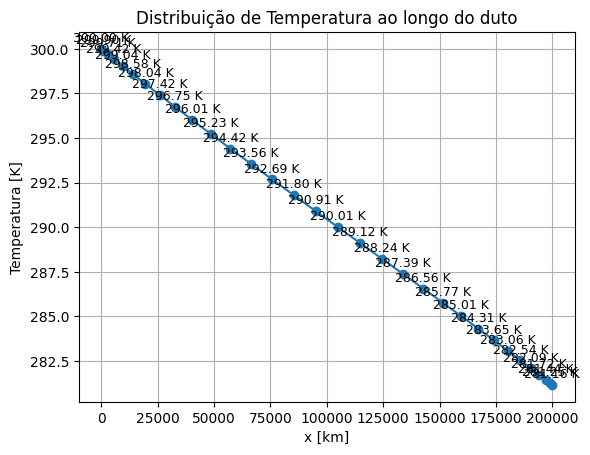

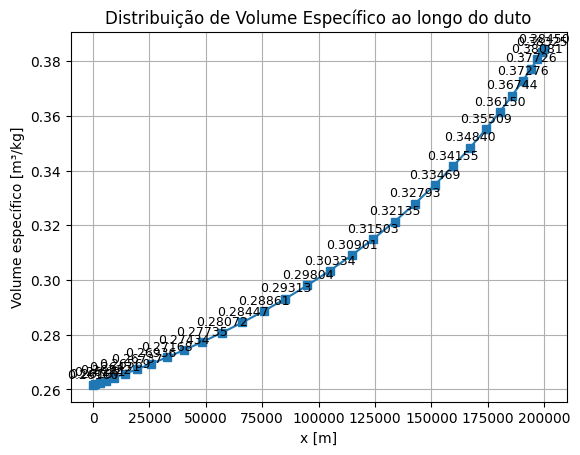

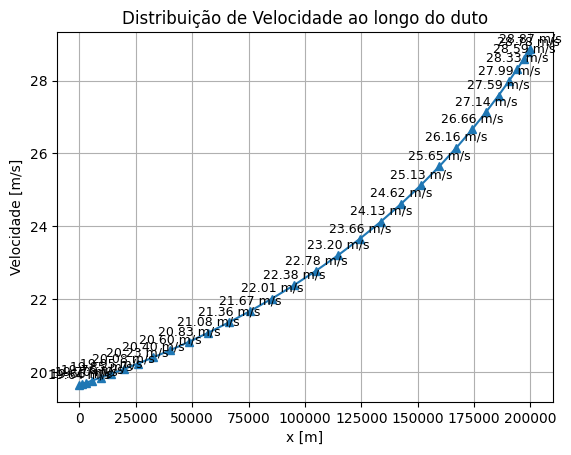

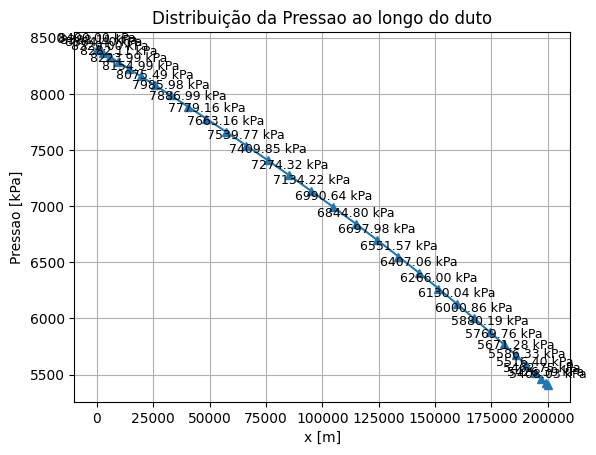

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# --- Temperatura (K) ---
plt.figure()
plt.plot(x_avaliar, T_sol_estc, marker='o', linestyle='-')
for xi, Ti in zip(x_avaliar, T_sol_estc):
    plt.annotate(f'{Ti:.2f} K', xy=(xi, Ti), xytext=(0, 5), textcoords='offset points', ha='center', fontsize=9)
plt.title('Distribuição de Temperatura ao longo do duto')
plt.xlabel('x [km]')
plt.ylabel('Temperatura [K]')
plt.grid(True)

# --- Volume específico (m³/kg) ---
plt.figure()
plt.plot(x_avaliar, V_sol_estc, marker='s', linestyle='-')
for xi, Vi in zip(x_avaliar, V_sol_estc):
    plt.annotate(f'{Vi:.5f}', xy=(xi, Vi), xytext=(0, 5), textcoords='offset points', ha='center', fontsize=9)
plt.title('Distribuição de Volume Específico ao longo do duto')
plt.xlabel('x [m]')
plt.ylabel('Volume específico [m³/kg]')
plt.grid(True)

# --- Velocidade (m/s) ---
plt.figure()
plt.plot(x_avaliar, w_sol_estc, marker='^', linestyle='-')
for xi, wi in zip(x_avaliar, w_sol_estc):
    plt.annotate(f'{wi:.2f} m/s', xy=(xi, wi), xytext=(0, 5), textcoords='offset points', ha='center', fontsize=9)
plt.title('Distribuição de Velocidade ao longo do duto')
plt.xlabel('x [m]')
plt.ylabel('Velocidade [m/s]')
plt.grid(True)


plt.figure()
plt.plot(x_avaliar, P_sol_estc, marker='^', linestyle='-')
for xi, Pi in zip(x_avaliar, P_sol_estc):
    plt.annotate(f'{Pi:.2f} kPa', xy=(xi, Pi), xytext=(0, 5), textcoords='offset points', ha='center', fontsize=9)
plt.title('Distribuição da Pressao ao longo do duto')
plt.xlabel('x [m]')
plt.ylabel('Pressao [kPa]')
plt.grid(True)

plt.show()


In [6]:
x0 = np.concatenate([T_sol_estc, V_sol_estc, w_sol_estc])
y0 = [T_sol_estc[-1], V_sol_estc[1], w_sol_estc[-1]]  # estado inicial completo
print(meu_duto.estacionario(0.0, y0))

(-0.000139332762120574, 8.226464094866849e-07, 9.069872880679248e-05)


In [7]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# --- Condição inicial (estado estacionário estimado) ---
T0 = T_sol_estc
V0 = V_sol_estc
w0 = w_sol_estc

y0 = np.empty(n_nodes * 3)
y0[0::3] = T0
y0[1::3] = V0
y0[2::3] = w0

# --- Função wrapper para o solve_ivp ---
def dae_wrapper(t, y):
    return meu_duto.evaluate_dae(t, y)

# --- Primeira simulação ---
t_span1 = (0, 100000)
t_eval1 = np.linspace(*t_span1, 100000)

sol1 = solve_ivp(
    dae_wrapper,
    t_span=t_span1,
    y0=y0,
    method='LSODA',
    t_eval=t_eval1
)

# --- Pegar o estado final da primeira simulação ---
y_final = sol1.y[:, -1]   # vetor (n_nodes * 3,)

# --- Nova condição inicial (pode adicionar perturbação se quiser) ---
y0_new = y_final.copy()

# Exemplo: pequena perturbação de temperatura no primeiro nó (opcional)
# y0_new[0] += 0.1  

# --- Segunda simulação (continuação) ---
t_span2 = (0, 20000)
t_eval2 = np.linspace(*t_span2, 20000)
sol2 = solve_ivp(
    dae_wrapper,
    t_span=t_span2,
    y0=y0_new,
    method='LSODA',
    t_eval=t_eval2
)

/home/matheusmarinho/Documentos/IC/Research_about_PINNs/Duto_Rede_de_gas/libs/duto.py:29: RuntimeWarning: invalid value encountered in log10
  return 0.25*float(-4 * np.log10(self.e_D / 3.7 / self.D - 5.02/ Re * np.log10(self.e_D/ 3.7 / self.D - 5.02/Re * np.log10(self.e_D / 3.7  / self.D + 13/Re))))**(-2)
/home/matheusmarinho/Documentos/IC/Research_about_PINNs/Duto_Rede_de_gas/libs/duto.py:36: RuntimeWarning: invalid value encountered in log10
  ft = (1.82*np.log10(Re) - 1.64)**(-2)
/home/matheusmarinho/Documentos/IC/Research_about_PINNs/Duto_Rede_de_gas/libs/viscosity.py:51: RuntimeWarning: invalid value encountered in multiply
  pvapm = sum(array(self.mixture.x) * array(pvap))
/home/matheusmarinho/Documentos/IC/Research_about_PINNs/Duto_Rede_de_gas/libs/viscosity.py:79: RuntimeWarning: invalid value encountered in scalar power
  alfa = 3.262 + 14.98 * (Prm**5.508)
/home/matheusmarinho/Documentos/IC/Research_about_PINNs/Duto_Rede_de_gas/libs/gc_eos_soave.py:253: RuntimeWarning: inval

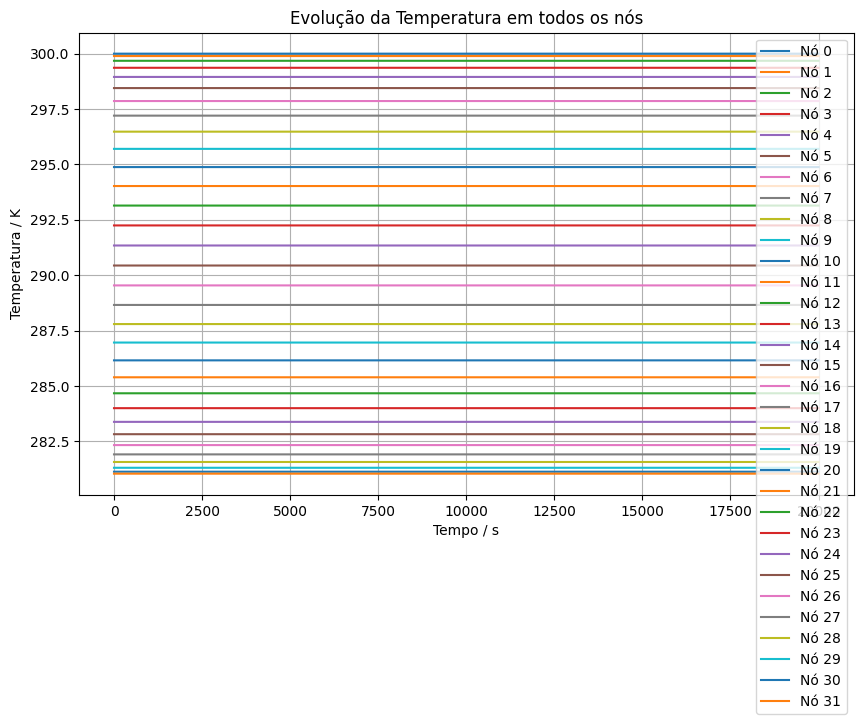

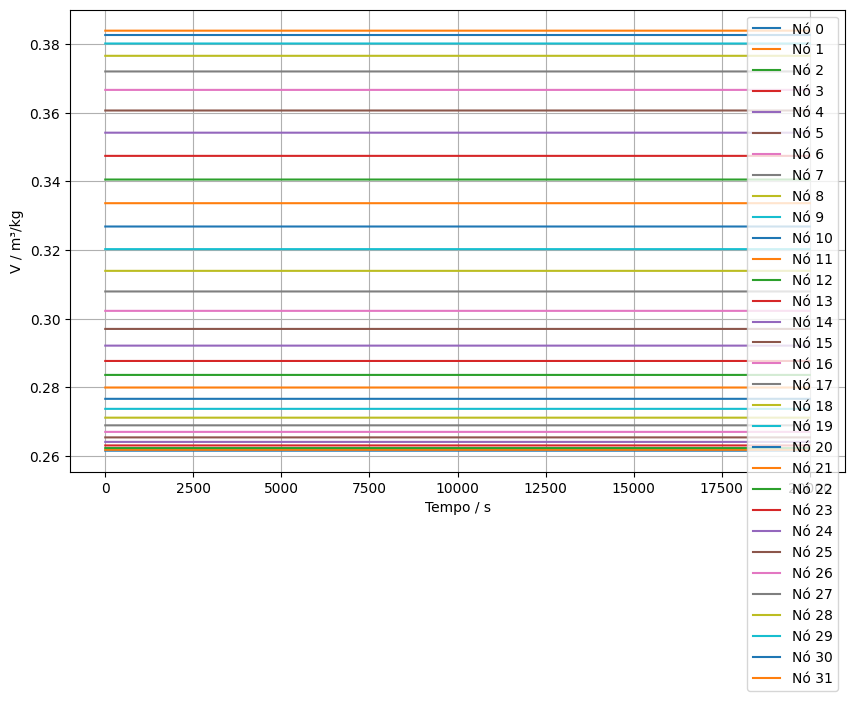

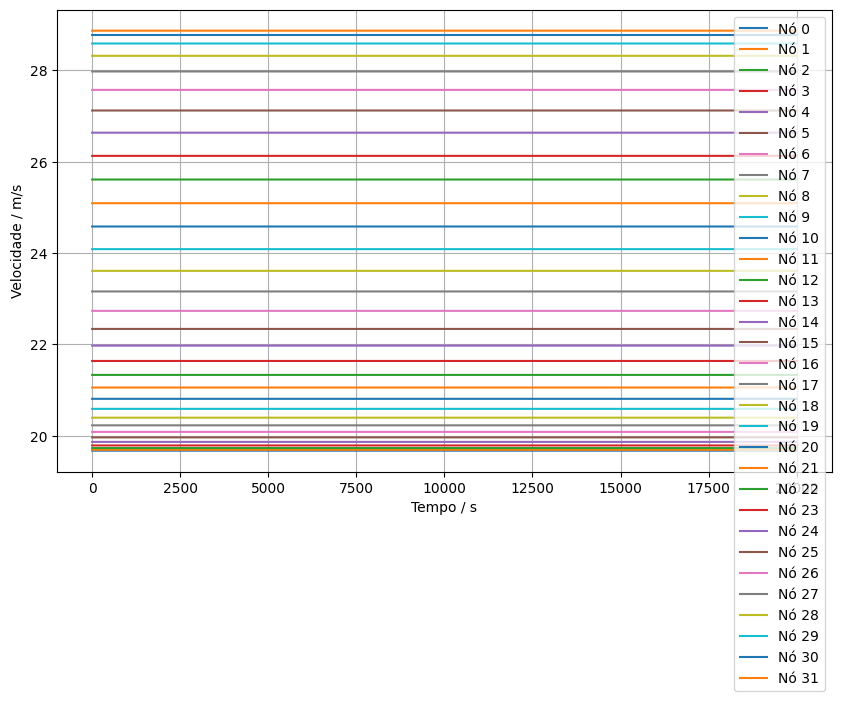

In [8]:
import matplotlib.ticker as mtick

plt.figure(figsize=(10, 6))
for i in range(n_nodes):
    plt.plot(sol2.t, sol2.y[0::3][i], label=f'Nó {i}')
plt.xlabel('Tempo / s')
plt.ylabel('Temperatura / K')
plt.title('Evolução da Temperatura em todos os nós')
plt.legend()
plt.grid(True)

ax = plt.gca()
ax.yaxis.set_major_formatter(mtick.ScalarFormatter())
ax.ticklabel_format(useOffset=False, style='plain')  # força números "normais"
plt.show()

plt.figure(figsize=(10, 6))
for i in range(n_nodes):
    plt.plot(sol2.t, sol2.y[1::3][i], label=f'Nó {i}')
plt.xlabel('Tempo / s')
plt.ylabel('V / m³/kg')
plt.legend()
plt.grid(True)

ax = plt.gca()
ax.yaxis.set_major_formatter(mtick.ScalarFormatter())
ax.ticklabel_format(useOffset=False, style='plain')
plt.show()

plt.figure(figsize=(10, 6))
for i in range(n_nodes):
    plt.plot(sol2.t, sol2.y[2::3][i], label=f'Nó {i}')
plt.xlabel('Tempo / s')
plt.ylabel('Velocidade / m/s')
plt.legend()
plt.grid(True)

ax = plt.gca()
ax.yaxis.set_major_formatter(mtick.ScalarFormatter())
ax.ticklabel_format(useOffset=False, style='plain')
plt.show()

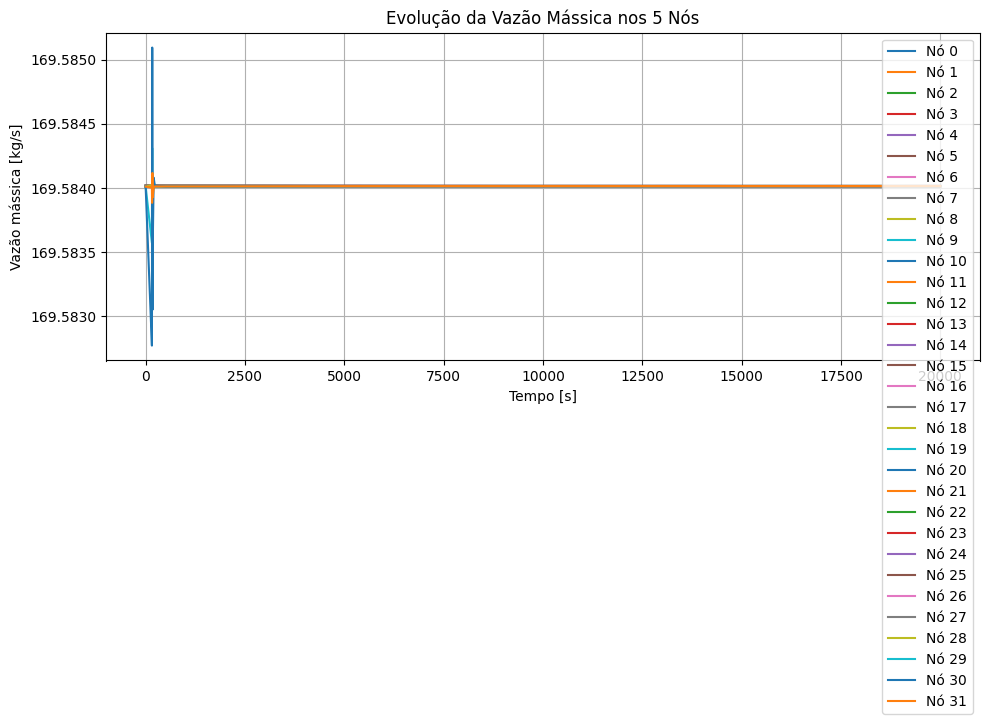

In [9]:
A = np.pi * (meu_duto.D**2) / 4
MM = meu_duto.gas.mixture.MM_m  # massa molar em kg/mol

# Número de instantes de tempo
n_t = len(sol2.t)

# Inicializa matriz de vazões mássicas (5 nós x n_t tempos)
m_dot = np.zeros((n_nodes, n_t))

# Calcula a vazão mássica para cada nó e tempo
for t_idx in range(n_t):
    for node in range(n_nodes):
        T = sol2.y[0::3][node][t_idx]
        V = sol2.y[1::3][node][t_idx]
        w = sol2.y[2::3][node][t_idx]

        v_kg = V / MM
        rho = 1 / v_kg
        m_dot[node, t_idx] = rho * A * w  # vazão mássica [kg/s]

# Plot da vazão mássica ao longo do tempo para os 5 nós
plt.figure(figsize=(10, 6))
for i in range (n_nodes):
    plt.plot(sol2.t, m_dot[i], label=f'Nó {i}')
plt.xlabel('Tempo [s]')
plt.ylabel('Vazão mássica [kg/s]')
plt.title('Evolução da Vazão Mássica nos 5 Nós')
plt.legend()
plt.grid(True)

ax = plt.gca()
ax.yaxis.set_major_formatter(mtick.ScalarFormatter())
ax.ticklabel_format(useOffset=False, style='plain')
plt.tight_layout()
plt.show()